## Step 1. Import necessary libraries

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

## Step 2. Create a function to convert image to grayscale and locate its position

•	xticks and yticks function denotes the data points and get the location of ticks on x and y axis.

In [15]:
def show(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

## Step 3. To access google drive directory

In [16]:
from google.colab import drive
drive.mount ('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Step 4. Displaying the image and making some changes

•	np.zeros function returns a new array of the desired shape and type. <br>
•	medianBlur() is used to smoothen an image by removing the noise in the image. <br>
•	cv2.threshold is used for image thresholding. Thresholding is converting an image to white or black depending on the threshold value.
> •	(Source Image (must be grayscale), threshold value, maximum value, type of thresholding) <br> 
> •	cv2.THRESH_BINARY is set to 255 if the pixel intensity is greater than the set threshold, otherwise, 0. <br>
> •	cv2.THRESH_OTSU pass as an extra flag and the threshold values can be arbitrary.



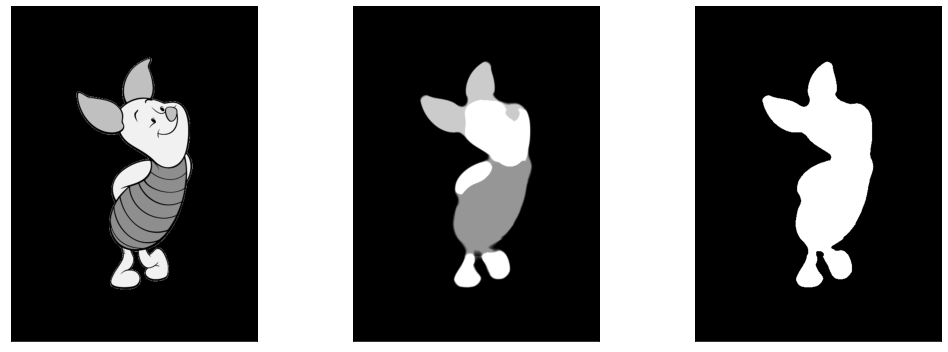

In [17]:
img_original = cv2.imread('/gdrive/My Drive/Colab Notebooks/piglet.png', 0)
h, w = img_original.shape
img = np.zeros((h+160,w), np.uint8)
img[80:-80,:] = img_original
plt.figure(figsize=(15,5))
plt.subplot(131)
show(img)

blur = cv2.medianBlur(img,(25))
plt.subplot(132)
show(blur)
_, th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(133)
show(th)
plt.tight_layout()
plt.show()

## Step 5. Image Moment and Image Contours

•	cv2.moments is used to find specific properties in an image such as area, radius, centroid, etc. <br>
•	cv2.erosion is used to erode an image by eroding the boundaries of foreground object (keeping foreground in white). <br>
•	Cv2.findContours is used to detect change and marks it contour from the binary images. <br>
•	cv2.drawContours is used to draw the contours in the image


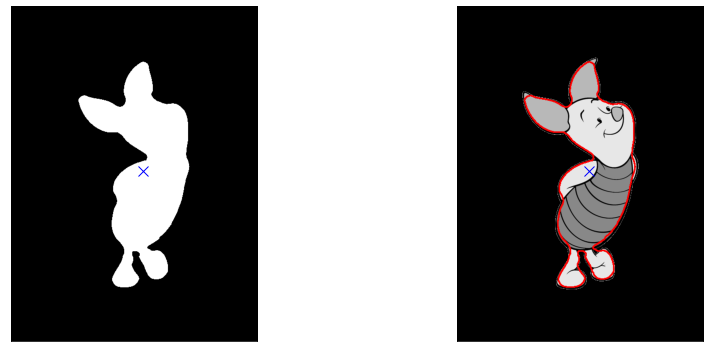

In [18]:
M = cv2.moments(th)
h, w = img.shape
x_c = M['m10'] // M['m00']
y_c = M['m01'] // M['m00']
plt.figure(figsize=(15,5))
plt.subplot(121)
show(th)
plt.plot(x_c, y_c, 'bx', markersize=10)
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]]).astype(np.uint8)
erosion = cv2.erode(th,kernel,iterations=1)
boundary = th - erosion

cnt, _ = cv2.findContours(boundary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_c = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cnt = cnt[0]
img_cnt = cv2.drawContours(img_c, [cnt], 0, (255,0,0), 2)
plt.subplot(122)
plt.plot(x_c, y_c, 'bx', markersize=10)
show(img_cnt)
plt.tight_layout()
plt.show()

cnt = cnt.reshape(-1,2)
left_id = np.argmin(cnt.sum(-1))
cnt = np.concatenate([cnt[left_id:,:], cnt[:left_id,:]])

## Step 6: Square Root

•	sqrt() is returns the square root in an array <br>
•	concatenate() to join the arrays <br>
•	fft.irfft() computes the inverse of the one-dimensional n-point discrete Fourier Transform of real input computed by rfft.


In [19]:
dist_c = np.sqrt(np.square(cnt-[x_c, y_c]).sum(-1))
f = np.fft.rfft(dist_c)
cutoff = 15
f_new = np.concatenate([f[:cutoff],0*f[cutoff:]])
dist_c_1 = np.fft.irfft(f_new)
#plt.figure(figsize=(15,5))
#plt.grid()
#plt.plot(dist_c, label='Original ED function', color='r', linewidth='3', linestyle='--')
#plt.plot(dist_c_1, label='Low frequency reconstruction', color='b', linestyle='-')
#plt.legend()
#plt.show()

## Step 7. Determine the Power Retained

In [20]:
eta = np.square(np.abs(f_new)).sum()/np.square(np.abs(f)).sum()
print('Power Retained: {:.4f}{}'.format(eta*100,'%'))

Power Retained: 99.9935%


## Step 8. Derivative

•	diff() calculates the difference between values in an array

In [21]:
derivative = np.diff(dist_c_1)
sign_change = np.diff(np.sign(derivative))/2
#plt.figure(figsize=(15,5))
#plt.plot(sign_change)
#plt.plot(derivative)
#plt.axhline(y=0, color='r')
#plt.grid()
#plt.show()

## Step 9. Rotating Image

•	getRotationMatrix2D() Is used to get the rotation matrix

The rotation of ROI is 48.37°


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

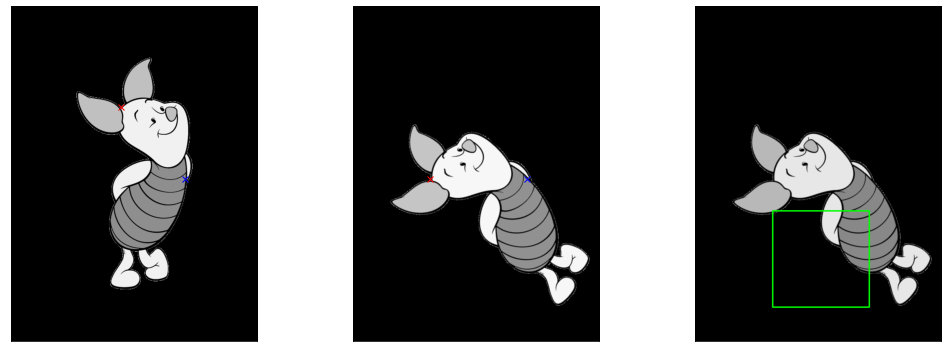

In [22]:
minimas = cnt[np.where(sign_change>0)[0]]
v1, v2 = minimas[-1], minimas[-3]
plt.figure(figsize=(15,5))
plt.subplot(131)
show(img)
plt.plot(v1[0], v1[1],'rx')
plt.plot(v2[0], v2[1],'bx')

plt.subplot(132)
theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi
print('The rotation of ROI is {:.02f}\u00b0'.format(theta))
R = cv2.getRotationMatrix2D(tuple(v2),theta,1)
img_r = cv2.warpAffine(img,R,(w,h))
v1 = (R[:,:2] @ v1 + R[:,-1]).astype(np.int)
v2 = (R[:,:2] @ v2 + R[:,-1]).astype(np.int)
plt.plot(v1[0], v1[1],'rx')
plt.plot(v2[0], v2[1],'bx')
show(img_r)

ux = v1[0]
uy = v1[1] + (v2-v1)[0]//3
lx = v2[0]
ly = v2[1] + 4*(v2-v1)[0]//3
img_c = cv2.cvtColor(img_r, cv2.COLOR_GRAY2BGR)
cv2.rectangle(img_c, (lx,ly),(ux,uy),(0,255,0),2)
plt.subplot(133)
show(img_c)

plt.tight_layout()
plt.show()

## Step 10. Display the ROI

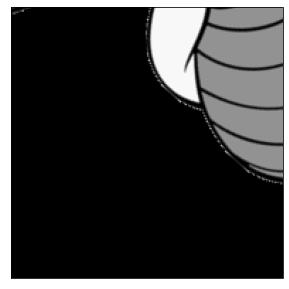

In [25]:
from PIL import Image
roi = img_r[uy:ly,ux:lx]
plt.figure(figsize=(5,5))
show(roi)

new_image = Image.fromarray(roi)
new_image.save('/gdrive/My Drive/Colab Notebooks/orig_pic.png')

## Step 11. Display the histogram of ROI

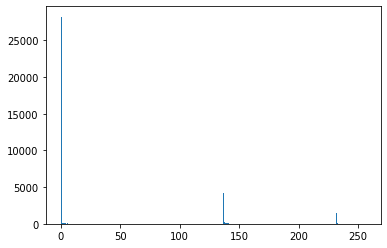

In [26]:
plt.hist(roi.ravel(),256,[0,256]); plt.show()

## Step 12. Importing the addtional libraries

In [28]:
from PIL import Image

In [27]:
from google.colab.patches import cv2_imshow

In [29]:
pip install sewar

  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=74d400b1f91221e2266b63dd9fb345d07ffb9eb4b6ee1cd09c759989162b0b7c
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [30]:
from sewar import full_ref
from skimage import measure, metrics

## Step 13. Setting the gaussian kernels to 3x4, 5x5, 7x7

In [31]:
gaussian_kernel_3 = np.ones((3,3),np.float32)/25
gaussian_kernel_5 = np.ones((5,5),np.float32)/25
gaussian_kernel_7 = np.ones((7,7),np.float32)/25

### 3X3 KERNEL

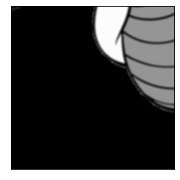

In [40]:
conv_gaussian_3 = cv2.filter2D(roi, -1, gaussian_kernel_3, borderType = cv2.BORDER_CONSTANT)

plt.figure(figsize=(3,3))
show(conv_gaussian_3)

new_image = Image.fromarray(conv_gaussian_3)
new_image.save('/gdrive/My Drive/Colab Notebooks/piglet3x3.png')

### 5X5 KERNEL

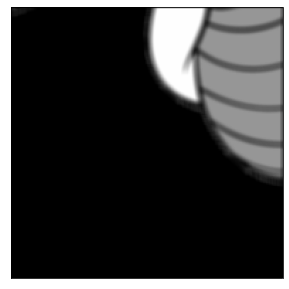

In [41]:
conv_gaussian_5 = cv2.filter2D(roi, -1, gaussian_kernel_5, borderType = cv2.BORDER_CONSTANT)

plt.figure(figsize=(5,5))
show(conv_gaussian_5)

new_image = Image.fromarray(conv_gaussian_5)
new_image.save('/gdrive/My Drive/Colab Notebooks/piglet5x5.png')

### 7X7 KERNEL

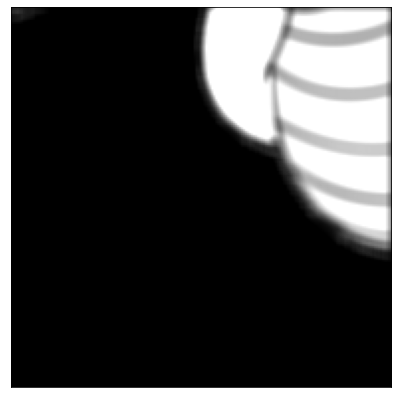

In [42]:
conv_gaussian_7 = cv2.filter2D(roi, -1, gaussian_kernel_7, borderType = cv2.BORDER_CONSTANT)

plt.figure(figsize=(7,7))
show(conv_gaussian_7)

new_image = Image.fromarray(conv_gaussian_7)
new_image.save('/gdrive/My Drive/Colab Notebooks/piglet7x7.png')

## EVALUATION

## Step 14. Reading the original image and gaussian kernel images

In [45]:
orig = cv2.imread('/gdrive/My Drive/Colab Notebooks/orig_pic.png', 1)
gaussian3 = cv2.imread('/gdrive/My Drive/Colab Notebooks/piglet3x3.png', 1)
gaussian5 = cv2.imread('/gdrive/My Drive/Colab Notebooks/piglet5x5.png', 1)
gaussian7 = cv2.imread('/gdrive/My Drive/Colab Notebooks/piglet7x7.png', 1)

### RMSE Evaluation

•	RMSE (Root Mean Squared Error) is a measure of how spread out the residuals are. It shows how concentrated the data is around the line of best fit. <br>
> •	A good RSME score values is between 0.2 and 0.5


In [46]:
rmse_skimg = metrics.normalized_root_mse(orig, gaussian3)
print("RMSE of 3x3: based on scikit-image = ", rmse_skimg)

rmse_skimg = metrics.normalized_root_mse(orig, gaussian5)
print("RMSE of 5x5: based on scikit-image = ", rmse_skimg)

rmse_skimg = metrics.normalized_root_mse(orig, gaussian7)
print("RMSE of 7x7: based on scikit-image = ", rmse_skimg)

RMSE of 3x3: based on scikit-image =  0.6517120604980399
RMSE of 5x5: based on scikit-image =  0.18577231831542937
RMSE of 7x7: based on scikit-image =  0.6606011614532667


### MSE Evaluation

•	MSE (Mean Squared Error) measures the average of the squares of the error. It shows how close a regression line to a set of points. <br>
> •	The lower the value the better, and 0 means the model is perfect.


In [47]:
mse_skimg = metrics.mean_squared_error(orig, gaussian3)
print("MSE of 3x3: based on scikit-image = ", mse_skimg)

mse_skimg = metrics.mean_squared_error(orig, gaussian5)
print("MSE of 5x5: based on scikit-image = ", mse_skimg)

mse_skimg = metrics.mean_squared_error(orig, gaussian7)
print("MSE of 7x7: based on scikit-image = ", mse_skimg)

MSE of 3x3: based on scikit-image =  2254.718994140625
MSE of 5x5: based on scikit-image =  183.20735677083334
MSE of 7x7: based on scikit-image =  2316.645453559028


### PSNR Evaluation

•	PSNR (Peak Signal to Noise Ratio) calculates the quality of reconstruction of lossy compression codes (image compression). <br>
> •	Higher value means good quality, lower value means bad quality. 


In [48]:
psnr_skimg = metrics.peak_signal_noise_ratio(orig, gaussian3, data_range=None)
print("PSNR of 3x3: based on scikit-image = ", psnr_skimg)

psnr_skimg = metrics.peak_signal_noise_ratio(orig, gaussian5, data_range=None)
print("PSNR of 5x5: based on scikit-image = ", psnr_skimg)

psnr_skimg = metrics.peak_signal_noise_ratio(orig, gaussian7, data_range=None)
print("PSNR of 7x7: based on scikit-image = ", psnr_skimg)

PSNR of 3x3: based on scikit-image =  14.599879374471364
PSNR of 5x5: based on scikit-image =  25.501374519027365
PSNR of 7x7: based on scikit-image =  14.48220787736065


### SSIM Evaluation

•	SSIM (Structural Similarity Index) measures the similarity between two images. <br>
> •	1 means perfect match, but in general, 0.97, 0.98, 0.99 for good quality reconstruction.


In [49]:
from skimage.metrics import structural_similarity as ssim

ssim_skimg = ssim(orig, gaussian3, data_range = img.max() - img.min(), multichannel = True)
print("SSIM of 3x3: based on scikit-image = ", ssim_skimg)

ssim_skimg = ssim(orig, gaussian5, data_range = img.max() - img.min(), multichannel = True)
print("SSIM of 5x5: based on scikit-image = ", ssim_skimg)

ssim_skimg = ssim(orig, gaussian7, data_range = img.max() - img.min(), multichannel = True)
print("SSIM of 7x7: based on scikit-image = ", ssim_skimg)

SSIM of 3x3: based on scikit-image =  0.8613938606135454
SSIM of 5x5: based on scikit-image =  0.9219293856968309
SSIM of 7x7: based on scikit-image =  0.8650014953450328


## CONCLUSION

### RMSE <br>
> Based on the results, 3x3 got 0.65, 5x5 achieved 0.18, and 7x7 acquired 0.66. It is said that a good RSME score values is between 0.2 and 0.5, therefore, I think for RMSE evaluation, the 5x5 got a good RMSE value.

### MSE <br>
> Based on the results, 3x3 got 2254, 5x5 achieved 183, and 7x7 acquired 2316. In analyzing a good MSE value, the lower the value the better, which means that 5x5 got a good MSE value.

### PSNR <br>
> Based on the results, 3x3 got 14, 5x5 achieved 25, and 7x7 acquired 14. In PSNR, the higher the better, so the 5x5 got a good value.

### SSIM <br>
> Based on the results, 3x3 got 0.86, 5x5 achieved 0.92, and 7x7 acquired 0.86. For SSIM value evaluation, the closer to 1 means good quality reconstruction. All three got a high value, however, 5x5 got highest accuracy with 92%.

### To sum up, based on the different evaluations, the 5x5 kernel got  good values.